# Volatility Forecasting using Econometric and Machine Learning Models  
### Notebook 03: Machine Learning Volatility Models

**Objective**  
This notebook applies supervised machine learning models to forecast daily volatility using observable features derived from return dynamics.

The goal is to:
- Build ML-based volatility forecasts
- Compare them against a GARCH benchmark
- Preserve time-series discipline (no look-ahead bias)

This notebook is fully independent and reloads all required data.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("seaborn-v0_8")

In [4]:
returns = pd.read_csv("returns.csv", index_col=0, parse_dates=True).squeeze()
realized_vol = pd.read_csv(
    "realized_volatility.csv",
    index_col=0,
    parse_dates=True
).squeeze()

returns.head(), realized_vol.head()


(Date
 2010-01-05    0.008696
 2010-01-06    0.000739
 2010-01-07   -0.003547
 2010-01-08   -0.003493
 2010-01-11    0.000886
 Name: log_return, dtype: float64,
 Date
 2010-01-05    7.562730e-05
 2010-01-06    5.455874e-07
 2010-01-07    1.257898e-05
 2010-01-08    1.219860e-05
 2010-01-11    7.853318e-07
 Name: realized_volatility, dtype: float64)

In [5]:
df = pd.DataFrame({
    "rv": realized_vol,
    "abs_ret": returns.abs(),
    "sq_ret": returns**2
})

# Rolling volatility features
df["rv_5"] = realized_vol.rolling(5).mean()
df["rv_10"] = realized_vol.rolling(10).mean()
df["rv_22"] = realized_vol.rolling(22).mean()

# Lag features
df["sq_ret_lag1"] = df["sq_ret"].shift(1)
df["rv_lag1"] = df["rv"].shift(1)

# Target: next-day realized volatility
df["target"] = df["rv"].shift(-1)

df = df.dropna()

df.head()


,rv,abs_ret,sq_ret,rv_5,rv_10,rv_22,sq_ret_lag1,rv_lag1,target
Date,,,,,,,,,
2010-02-04,0.000313,0.017695,0.000313,0.000195,0.000274,0.000139,0.000435,0.000435,0.000702
2010-02-05,0.000702,0.026497,0.000702,0.000333,0.000283,0.000167,0.000313,0.000313,0.000078
2010-02-08,0.000078,0.008809,0.000078,0.000346,0.000278,0.000171,0.000702,0.000702,0.000046
2010-02-09,0.000046,0.006752,0.000046,0.000315,0.000279,0.000172,0.000078,0.000078,0.000055
2010-02-10,0.000055,0.007424,0.000055,0.000239,0.000186,0.000174,0.000046,0.000046,0.000211


## Train–Test Split

We use a **chronological split**, not random sampling.

This preserves:
- Temporal ordering
- Realistic forecasting conditions


In [6]:
split_date = "2020-01-01"

train = df.loc[df.index < split_date]
test = df.loc[df.index >= split_date]

X_train = train.drop(columns="target")
y_train = train["target"]

X_test = test.drop(columns="target")
y_test = test["target"]

X_train.shape, X_test.shape


((2421, 8), (1482, 8))

## Random Forest Volatility Model

Random Forests:
- Capture non-linearities
- Handle interactions automatically
- Are robust to noisy features

They are commonly used as a strong ML baseline in volatility forecasting.


“I used a Random Forest to forecast volatility because it captures non-linear interactions between lagged returns and rolling volatility without imposing parametric assumptions. Each tree learns threshold-based rules, and averaging across trees reduces overfitting, making it a robust benchmark against GARCH.”

In [7]:
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=6, n_estimators=300, n_jobs=-1, random_state=42)

In [8]:
rf_pred = rf.predict(X_test)

rf_pred = pd.Series(
    rf_pred,
    index=X_test.index,
    name="rf_vol_forecast"
)

rf_pred.head()


,rf_vol_forecast
Date,
2020-01-01,0.000046
2020-01-02,0.000042
2020-01-03,0.000037
2020-01-06,0.000058
2020-01-07,0.000088


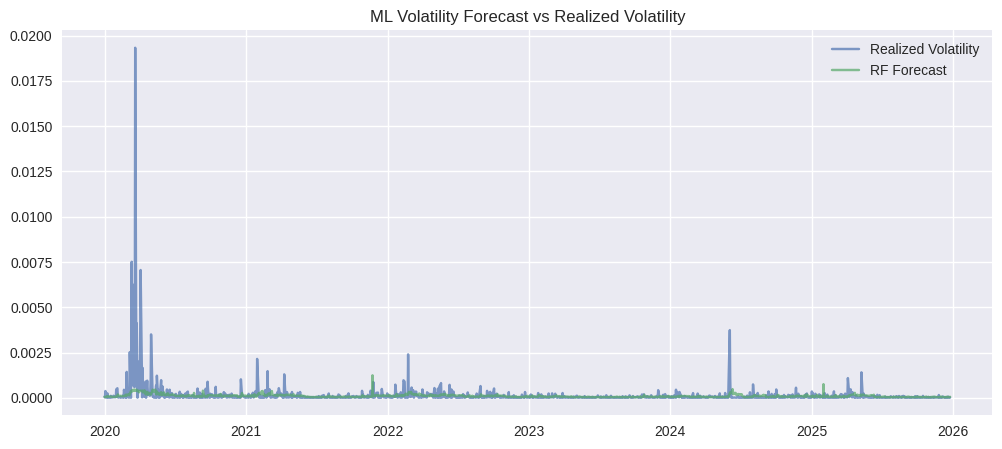

In [9]:
plt.figure(figsize=(12,5))
plt.plot(y_test, label="Realized Volatility", alpha=0.7)
plt.plot(rf_pred, label="RF Forecast", alpha=0.7)
plt.legend()
plt.title("ML Volatility Forecast vs Realized Volatility")
plt.show()


In [10]:
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
mae = mean_absolute_error(y_test, rf_pred)

pd.Series({
    "RMSE": rmse,
    "MAE": mae
})


,0
RMSE,0.000637
MAE,0.000138


In [13]:
rf_pred

,rf_vol_forecast
Date,
2020-01-01,0.000046
2020-01-02,0.000042
2020-01-03,0.000037
2020-01-06,0.000058
2020-01-07,0.000088
...,...
2025-12-18,0.000052
2025-12-19,0.000040
2025-12-22,0.000032


In [11]:
rf_pred.to_csv("rf_volatility_forecast.csv")

## Summary

In this notebook, we:
- Engineered volatility-related features
- Trained a Random Forest volatility model
- Generated out-of-sample forecasts
- Saved ML predictions for evaluation

The next notebook will formally compare ML and GARCH forecasts using:
- Loss functions
- VaR backtesting
- Risk validation metrics
